In [1]:
# import the libraries

import pandas as pd
import yfinance as yf
from arch import arch_model

In [4]:
# specify the risky assets

RISKY_ASSETS = ['GOOG', 'MSFT', 'AAPL']

N = len(RISKY_ASSETS)
START_DATE = '2015-01-01'
END_DATE = '2020-12-31'


In [5]:
# download data 

df = yf.download(RISKY_ASSETS, start = START_DATE,
                end = END_DATE, adjusted = True)

[*********************100%***********************]  3 of 3 completed


/Users/anna/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/__init__.py:61: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()


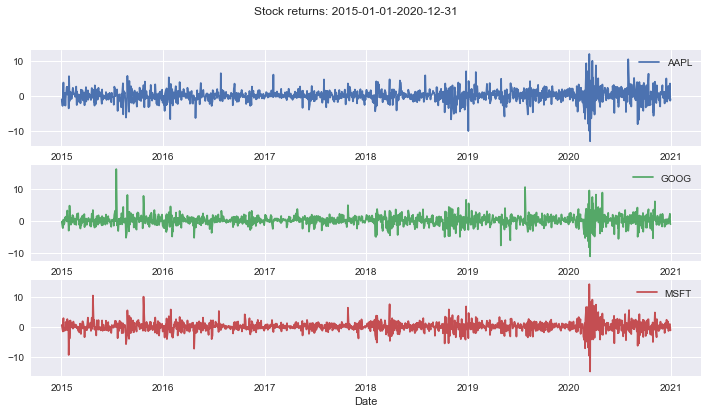

In [13]:
# calculate the daily returns
import matplotlib.pyplot as plt
plt.style.use('seaborn')
fig, axes = plt.subplots(figsize = (12, 6))
returns = 100 * df['Adj Close'].pct_change().dropna()
returns.plot(subplots = True, title = f'Stock returns: {START_DATE}-{END_DATE}', ax = axes)
plt.show()

In [15]:
# define lists for storing objects
coeffs = []
cond_vol = []
std_resids = []
models = []

In [16]:
# estimate the univariate garch models

for asset in returns.columns:
    model = arch_model(returns[asset], mean = 'Constant', vol = 'GARCH', p = 1, o = 0, q = 1).fit(update_freq = 0,
                                                                                                    disp = 'off')
    coeffs.append(model.params)
    cond_vol.append(model.conditional_volatility)
    std_resids.append(model.resid / model.conditional_volatility)
    models.append(model)

In [19]:
# store the results in df

coeffs_df = pd.DataFrame(coeffs, index=returns.columns)
cond_vol_df = pd.DataFrame(cond_vol).transpose().set_axis(returns.columns, 
                                                          axis = 'columns',
                                                          inplace = False)
std_resids_df = pd.DataFrame(std_resids).transpose().set_axis(returns.columns,
                                                             axis = 'columns',
                                                             inplace=False)

In [20]:
coeffs_df

,mu,omega,alpha[1],beta[1]
AAPL,0.196093,0.180926,0.145504,0.803447
GOOG,0.117260,0.322269,0.193567,0.704221
MSFT,0.140648,0.269205,0.231539,0.693439


In [21]:
cond_vol_df

,AAPL,GOOG,MSFT
Date,,,
2015-01-02,1.962414,1.530072,2.014711
2015-01-05,1.861881,1.415969,1.774304
2015-01-06,2.070573,1.634820,1.646974
2015-01-07,1.905412,1.830865,1.658050
2015-01-08,1.819229,1.642859,1.571989
...,...,...,...
2020-12-23,1.953325,1.262932,1.330282
2020-12-24,1.833759,1.214972,1.406955
2020-12-28,1.711953,1.172398,1.318081


In [22]:
std_resids_df

,AAPL,GOOG,MSFT
Date,,,
2015-01-02,-0.584664,-0.274045,0.261445
2015-01-05,-1.618381,-1.555001,-0.597543
2015-01-06,-0.090168,-1.489439,-0.976561
2015-01-07,0.633009,-0.157623,0.681452
2015-01-08,2.004217,0.120551,1.781937
...,...,...,...
2020-12-23,-0.457525,0.315117,-1.085914
2020-12-24,0.313632,0.210880,0.456364
2020-12-28,1.974637,1.726705,0.646015


In [23]:
# calculate the constant conditional correlation matrix (CCC) R:

R = std_resids_df.transpose().dot(std_resids_df).div(len(std_resids_df))

In [26]:
# calculate one step ahead forecastof the conditional covariance matrix
import numpy as np
diag = []
D = np.zeros((N, N))

for model in models:
    diag.append(model.forecast(horizon = 1).variance.values[-1][0])
    
diag = np.sqrt(np.array(diag))
np.fill_diagonal(D, diag)

H = np.matmul(np.matmul(D, R.values), D)

In [27]:
H

array([[3.47174918, 1.38404725, 1.31286198],
       [1.38404725, 2.0289716 , 1.20113175],
       [1.31286198, 1.20113175, 1.64230982]])